In [1]:

import tensorflow
from  tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

## Exploración y preparación

In [2]:
def show_images(data_folder):
    classes = os.listdir(data_folder)
    classes.sort()
    print(f'{len(classes)} classes:')
    fig = plt.figure(figsize=(8, 15))
    for i, sub_dir in enumerate(classes, 1):
        sub_dir_path = os.path.join(data_folder, sub_dir)
        img_files = [f for f in os.listdir(sub_dir_path) if f.endswith('.png') or f.endswith('.jpg')]
        if len(img_files) == 0:
            continue
        img_file = img_files[0]
        img_path = os.path.join(sub_dir_path, img_file)
        img = mpimg.imread(img_path)
        a = fig.add_subplot(1, len(classes), i)
        a.axis('off')
        imgplot = plt.imshow(img)
        a.set_title(img_file)
    plt.show()

In [3]:
data_folder = '../Cancer/Train'
show_images(data_folder)

FileNotFoundError: [Errno 2] No such file or directory: '../Cancer/Train'

In [64]:
def prepare_data(img_size, batch_size, validation_split):
    print("Getting Data...")
    datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                                validation_split=0.3) # hold back 30% of the images for validation

    print("Preparing training dataset...")
    train_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training') # set as training data

    print("Preparing validation dataset...")
    validation_generator = datagen.flow_from_directory(
        data_folder,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation') # set as validation data

    classnames = list(train_generator.class_indices.keys())
    print('Data generators ready')

    return train_generator, validation_generator, classnames

In [65]:
# Define el tamaño de las imágenes, el tamaño del lote y el porcentaje de validación
img_size = (128, 128)
batch_size = 64
validation_split = 0.3

# Prepara los datos de entrenamiento y validación
train_generator, validation_generator, classnames = prepare_data(img_size, batch_size, validation_split)

Getting Data...
Preparing training dataset...
Found 8316 images belonging to 2 classes.
Preparing validation dataset...
Found 3563 images belonging to 2 classes.
Data generators ready


## CNN

In [73]:

def build_model(train_generator):
    print("Building model...")
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=train_generator.image_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),  # Capa adicional completamente conectada
        Dense(train_generator.num_classes, activation='sigmoid')
    ])

    # Compilar el modelo usando el optimizador SGD con momentum
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])

    print(model.summary())
    return model

def train_model(model, train_generator, validation_generator, num_epochs):
    print("Training model...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=num_epochs
    )
    return history

In [74]:
# Construye el modelo
model = build_model(train_generator)

# Entrena el modelo
num_epochs = 90

history = train_model(model, train_generator, validation_generator, num_epochs)

Building model...


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/90
 11/129 ━━━━━━━━━━━━━━━━━━━━ 40s 341ms/step - accuracy: 0.5417 - loss: 0.7692

KeyboardInterrupt: 

## Evaluación

In [ ]:
def plot_loss(history, num_epochs):
    epoch_nums = range(1, num_epochs + 1)
    training_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.tight_layout()
    #plt.savefig('../resultados/learning_curve_cnn.png')
    plt.show()

def evaluate_model(model, validation_generator, classes):
    print("Generating predictions from validation data...")
    x_test = validation_generator[0][0]
    y_test = validation_generator[0][1]
    class_probabilities = model.predict(x_test)
    predictions = np.argmax(class_probabilities, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(true_labels, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("Evaluating model accuracy...")
    test_loss, test_accuracy = model.evaluate(validation_generator)
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)

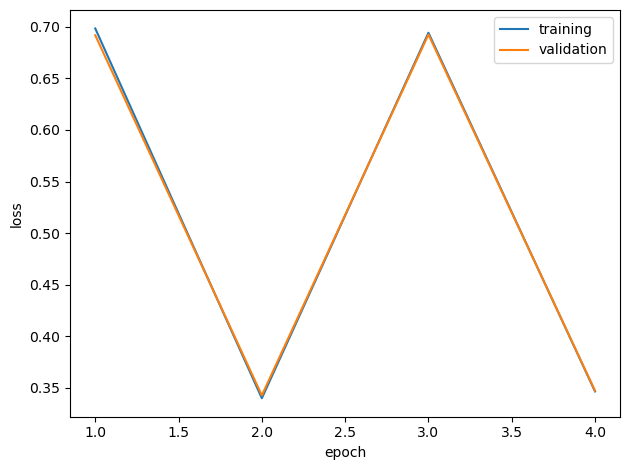

Generating predictions from validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


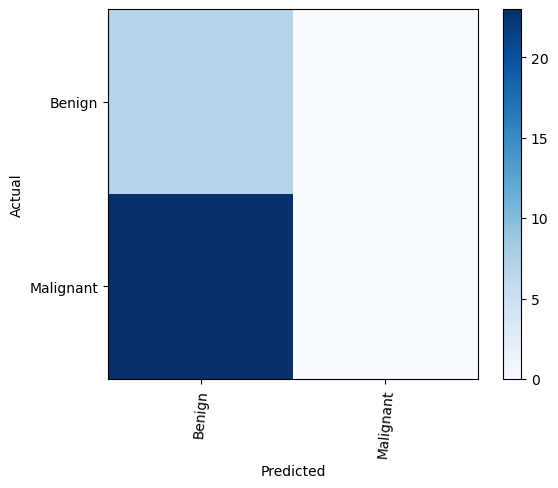

Evaluating model accuracy...
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5079 - loss: 0.6931
Test loss: 0.691981315612793
Test accuracy: 0.529329240322113


In [ ]:
plot_loss(history, num_epochs)
evaluate_model(model, validation_generator, classnames)

In [ ]:
'''
# Save the trained model
modelFileName = '../modelos/logo_classifier.keras'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)
'''